In [1]:
import brutus
import h5py
from astropy.io import fits
%pylab inline
from brutus import filters
from brutus.utils import inv_magnitude
from brutus import fitting
from brutus import plotting as bplot

/home/rybizki/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rybizki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
print('All bands:', filters.FILTERS,'\n')

filt = filters.bessell[1:3] + filters.ukidss[2:]
print('Current subset:', filt)

# import Bayestar models
(models_bs, labels_bs, 
 lmask_bs) = brutus.load_models('data/brutus/grid_bayestar_v4.h5', 
                                filters=filt)
Nmodels_bs, _, _ = models_bs.shape

print('Number of Bayestar models:', Nmodels_bs)

# import MIST models
(models_mist, labels_mist,
 lmask_mist) = brutus.load_models('data/brutus/grid_mist_v7.h5', 
                                  filters=filt, include_ms=True, 
                                  include_postms=True, include_binaries=True)
Nmodels_mist, _, _ = models_mist.shape

print('Number of MIST models:', Nmodels_mist)

# load in fitter

BF_bs = fitting.BruteForce(models_bs, labels_bs, lmask_bs)
BF_mist = fitting.BruteForce(models_mist, labels_mist, lmask_mist)

All bands: ['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', 'PS_w', 'PS_open', 'DECam_u', 'DECam_g', 'DECam_r', 'DECam_i', 'DECam_z', 'DECam_Y', 'Tycho_B', 'Tycho_V', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 'Hipparcos_Hp', 'Kepler_D51', 'Kepler_Kp', 'TESS'] 

Current subset: ['Bessell_B', 'Bessell_V', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K']
Number of Bayestar models: 


Reading filter UKIDSS_K            


40896
Number of MIST models: 1698620


In [3]:
# define parallax treatment

def external_uncertainty(internal_uncertainty):
    k = 1.08
    sigma_s = 0.021# for stars G>13: 0.043
    return(np.sqrt( k**2 * internal_uncertainty**2 + sigma_s**2))

def add_parallax_zero_point(parallax):
    #we take the zero point for brighter sources, not for the quasar sample
    return(parallax+0.050)

# define printout
def print_out_results(labels,idxs, dists):
    for item in labels.dtype.names:
        #in brutus the quantiles are [2.5, 50, 97.5]
        median = np.percentile(labels[idxs][item],50)
        upper = np.percentile(labels[idxs][item],84)
        lower = np.percentile(labels[idxs][item],16)
        if item in ["logt", "loga","logl"]:
            median = np.power(10,median)
            upper = np.power(10,upper)
            lower = np.power(10,lower)
            if item == "loga":
                median /= 1e9
                upper /= 1e9
                lower /= 1e9
        print(item, median, "+", upper-median, "-", median-lower)
    median = 1000*np.percentile(dists,50)
    upper = 1000*np.percentile(dists,84)
    lower = 1000*np.percentile(dists,16)
    print("distance in pc", median, "+", upper-median, "-", median-lower)

In [4]:
# preparing the data
objid = np.array(["HD33142","HD76700","HD205739"])
parallax_list = []
parallax_error_list = []
l_list = []
b_list = []
mag_list = []
magerr_list = []
# Data from GaiaDR2
for item in objid:
    print(item)
    data = fits.getdata(item+".fits")
    parallax_list.append(add_parallax_zero_point(data.parallax))
    parallax_error_list.append(external_uncertainty(data.parallax_error))
    l_list.append(data['l'])
    b_list.append(data['b'])
    
# Data from Simbad
mag_list.append(np.array([8.905,7.96,6.345,5.903,5.792]))
magerr_list.append(np.array([0.018,0.01,0.018,0.034,0.018]))

mag_list.append(np.array([8.88, 8.13, 6.911, 6.613, 6.5]))
magerr_list.append(np.array([0.02, 0.01, 0.023, 0.036, 0.024]))

mag_list.append(np.array([9.09, 8.54, 7.585, 7.350, 7.299]))
magerr_list.append(np.array([0.02, 0.01, 0.024, 0.038, 0.026]))

mag = np.vstack(mag_list)
magerr = np.vstack(magerr_list)

# Preparing for input to the fitting routine

objid = np.array([33142,76700,205739])

mask = np.isfinite(magerr)  # create boolean band mask
phot, err = inv_magnitude(mag, magerr)  # convert to flux
parallax, parallax_err = np.hstack(parallax_list), np.hstack(parallax_error_list)   # convert to mas
psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[np.hstack(l_list), np.hstack(b_list)]

Nobjs = len(phot)
print(Nobjs)

filename = 'planetary_hosts'

HD33142
HD76700
HD205739
3


Fitting object 3/3 (mean time: 4.403 s/obj, est. time remaining:      0.000 s)


Best-fit chi2 (MIST): 1.2392828


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=490.0, right=490.0
  'left=%s, right=%s') % (left, right))
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=490.0, top=490.0
  'bottom=%s, top=%s') % (bottom, top))
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0


Best-fit chi2 (MIST): 4.2778163
Best-fit chi2 (MIST): 1.0964509


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


########################################
HD33142
mini 1.260000000000001 + 0.06000000000000005 - 0.06000000000000005
feh -0.09999999999999654 + 0.06000000000000005 - 0.06000000000000005
eep 490.0 + 0.0 - 0.0
smf 0.0 + 0.0 - 0.0
loga 4.415789135172397 + 0.5892117024792238 - 0.6763419542817597
logl 9.403158460089019 + 0.1938124620756394 - 0.2442211942858048
logt 4938.534259630343 + 25.03787170596297 - 22.86407246028284
logg 3.289606870650521 + 0.02846000454774744 - 0.013937564738081054
agewt 9400933.177168287 + 202405.31258424558 - 234105.60718036257
distance in pc 120.98466604948044 + 0.5217492580413818 - 0.661209225654602
########################################
HD76700
mini 1.0400000000000007 + 0.040000000000000036 - 0.0
feh 0.26000000000000334 + 0.120000000000001 - 0.0
eep 442.0 + 0.0 - 96.0
smf 0.0 + 0.9 - 0.0
loga 9.90087387238704 + 0.0 - 6.797391395678384
logl 1.7190459852995637 + 0.0 - 0.6542845337418277
logt 5591.314459585769 + 51.261215650350096 - 28.074209447322573
logg 4.16440

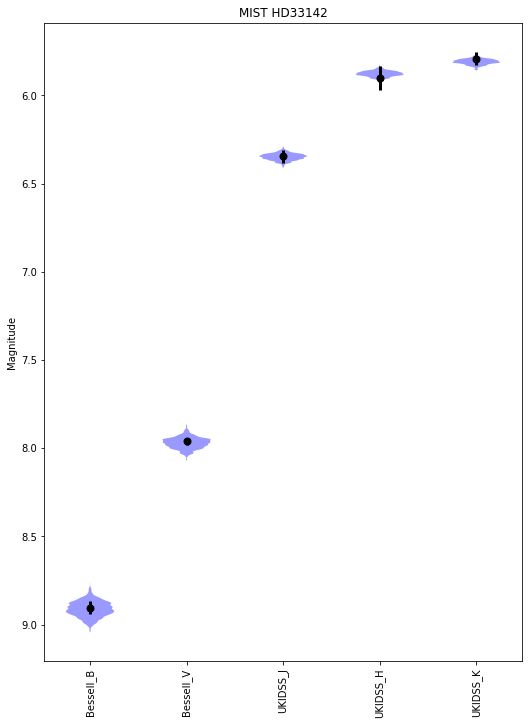

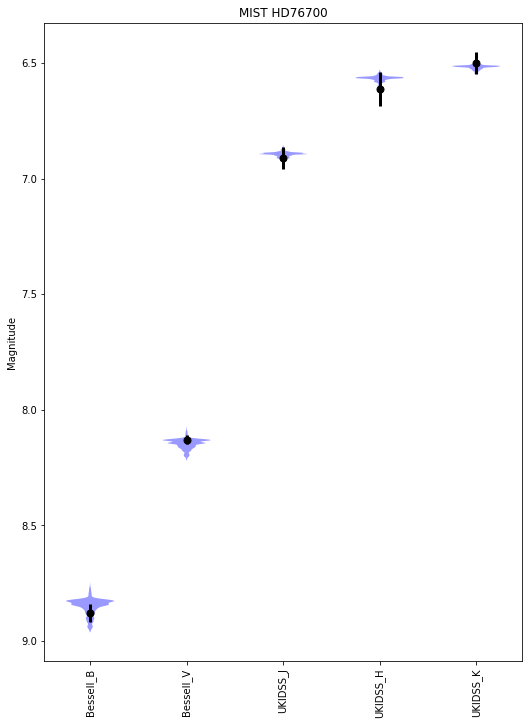

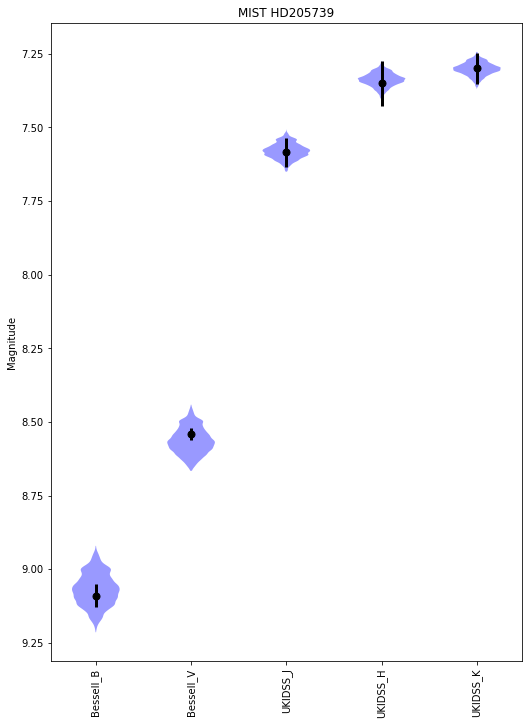

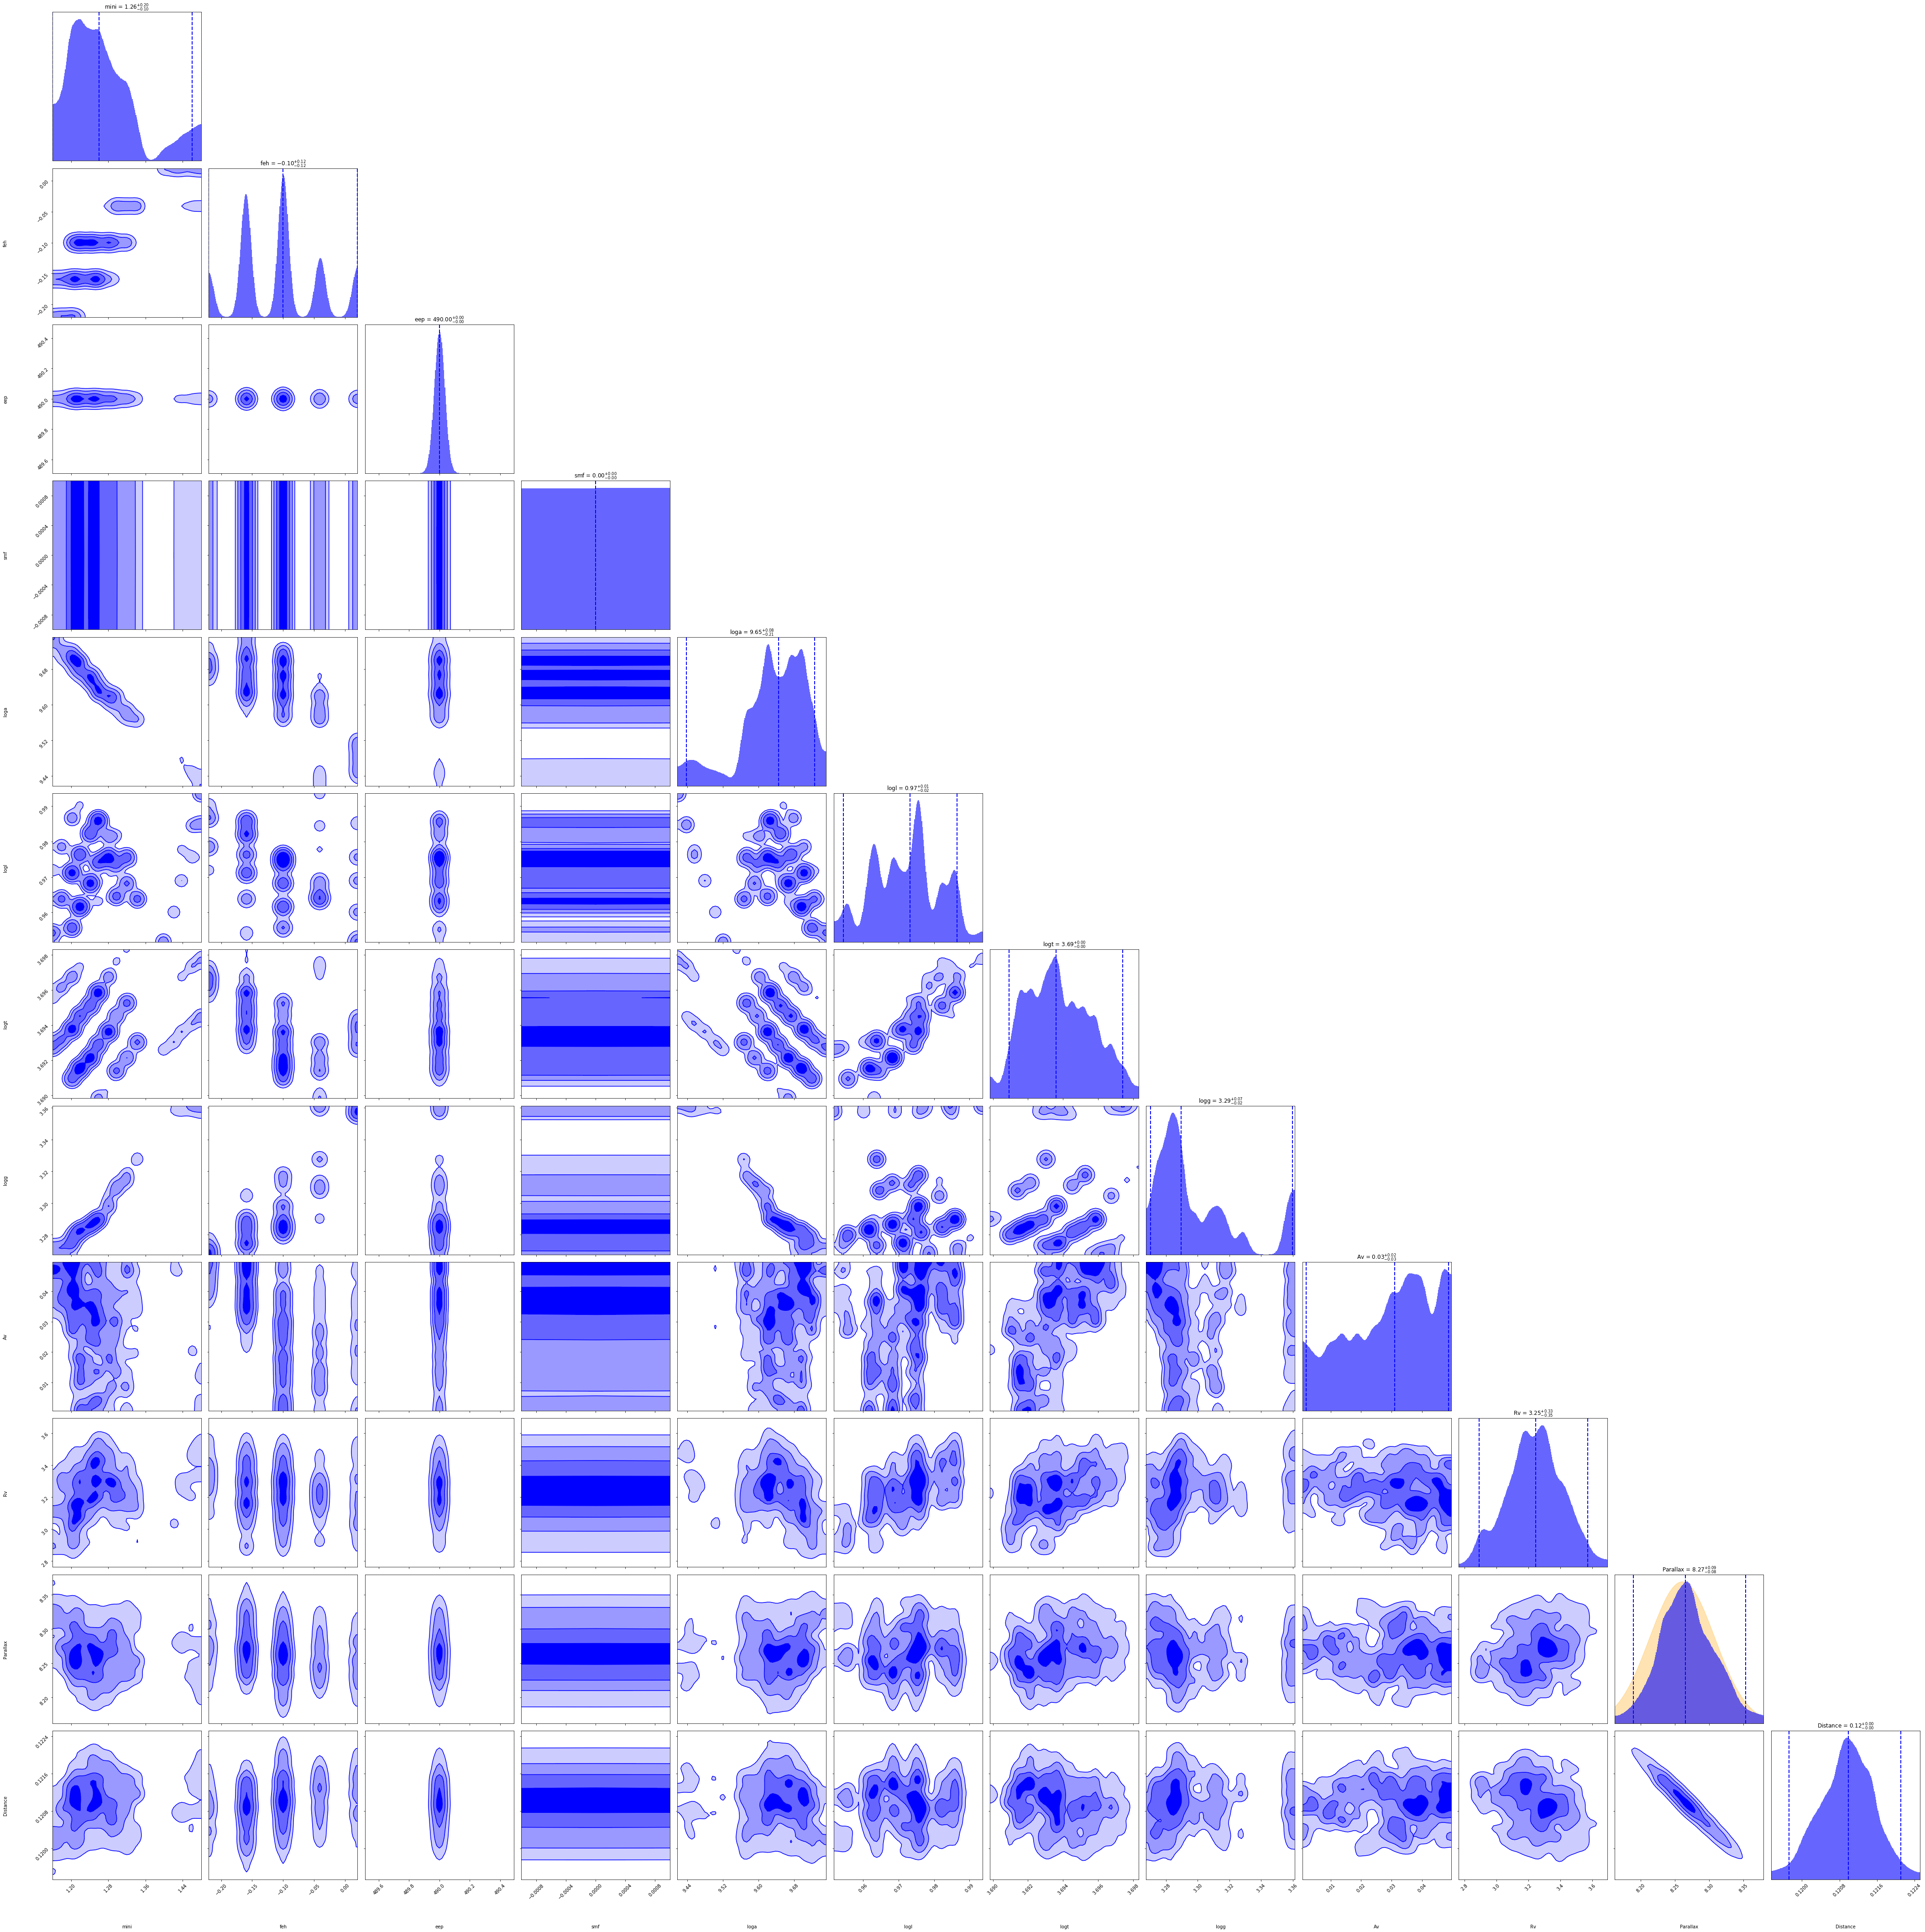

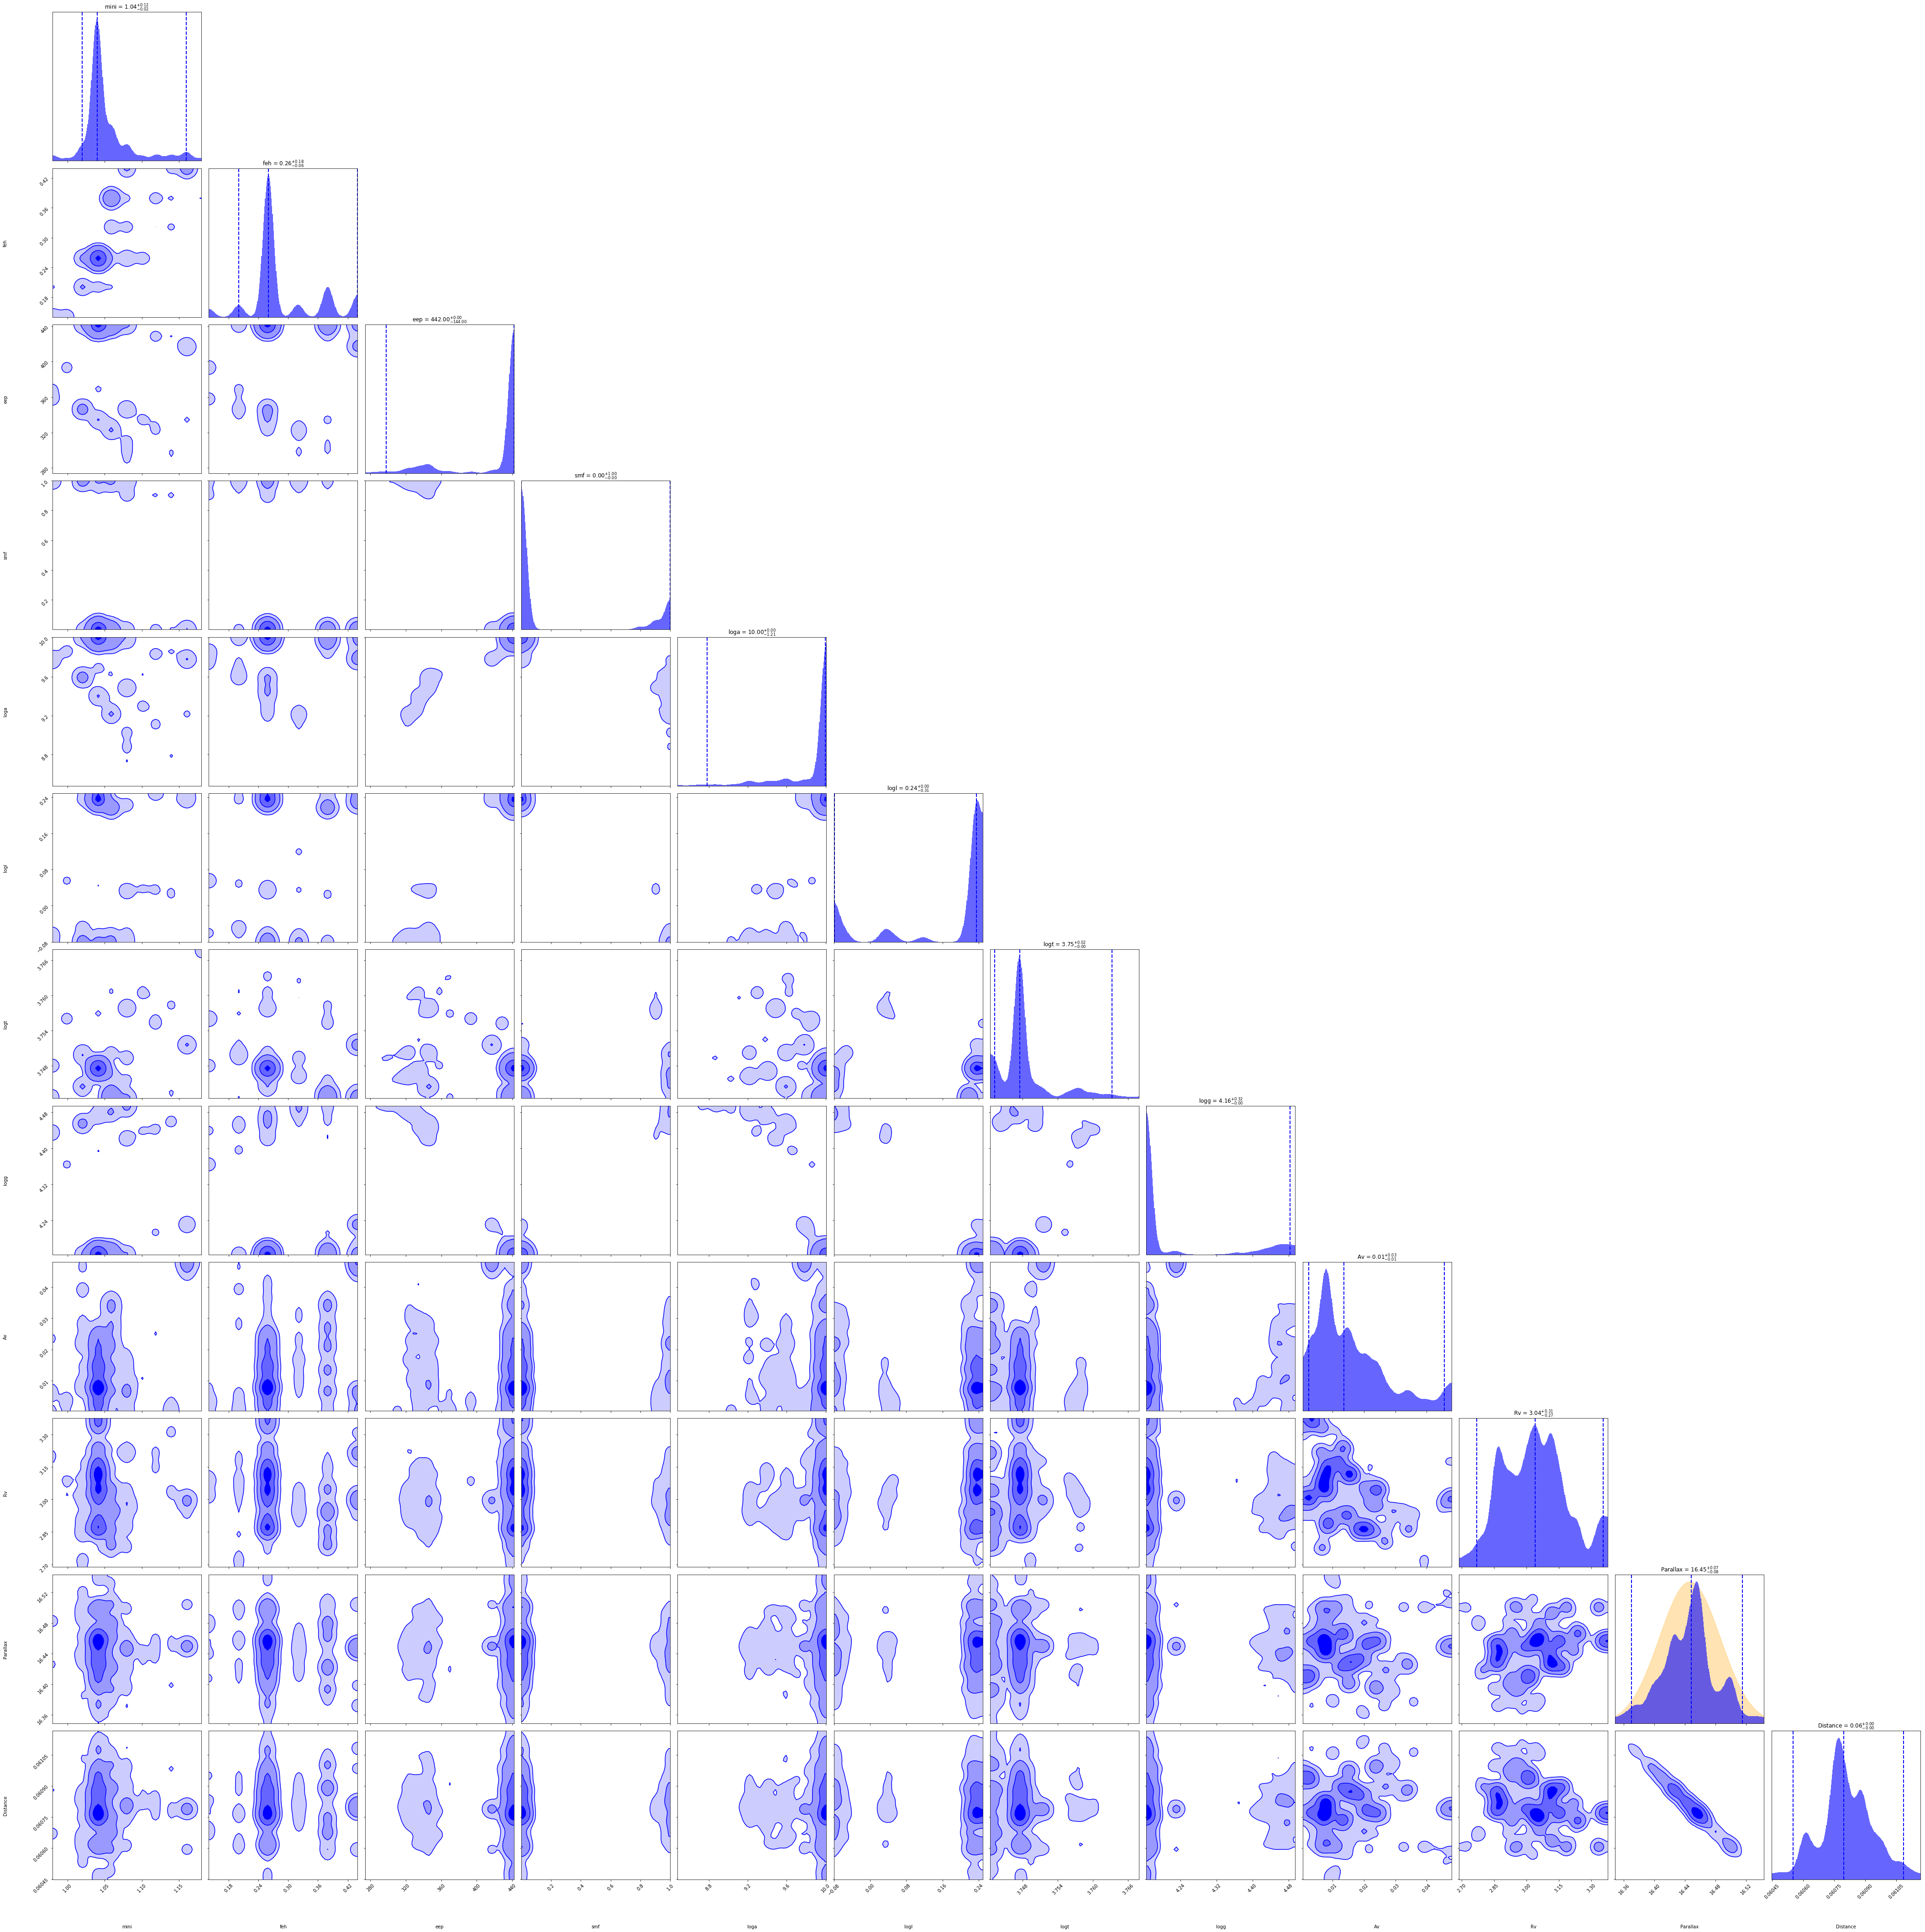

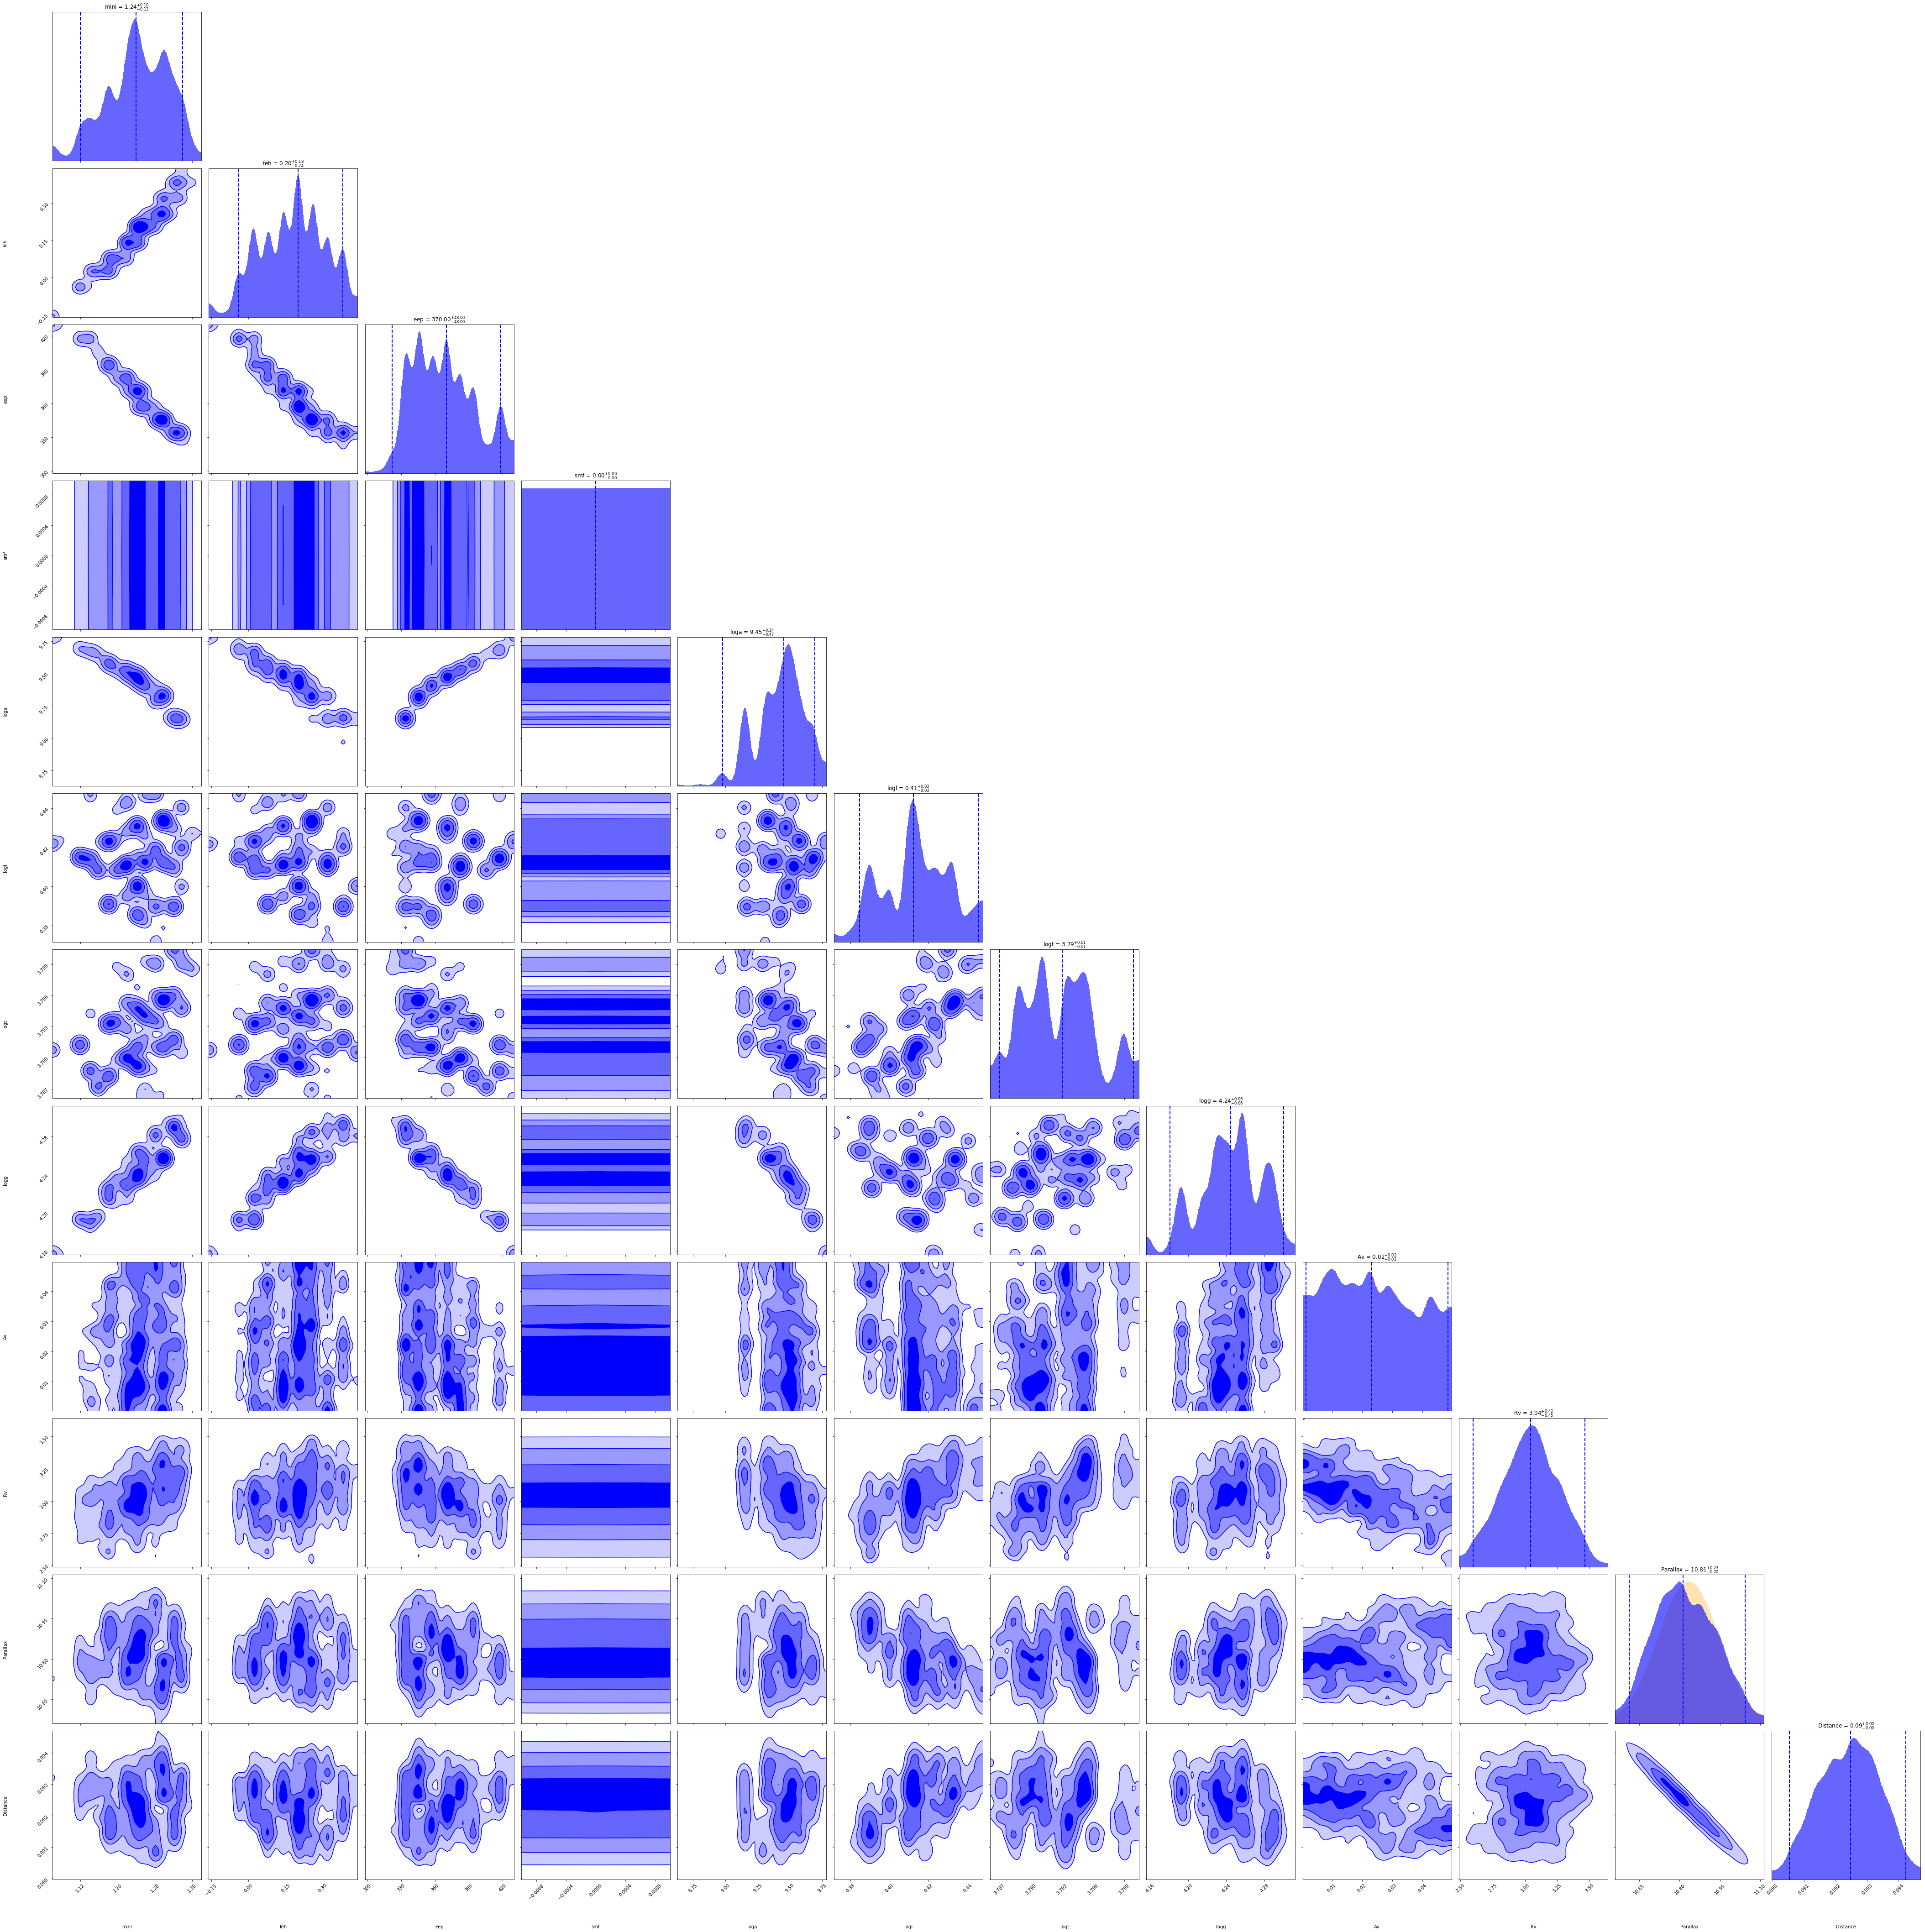

In [5]:
# fittign MIST isochrones
BF_mist.fit(phot, err, mask, objid, 
            filename+'_mist',
            parallax=parallax, parallax_err=parallax_err, 
            data_coords=coords, 
            dustfile='data/brutus/bayestar2017_v1.h5',
            phot_offsets=None,
            running_io=False,
           Ndraws=10000,
           avlim=(0.0, 0.05))

# load MIST results
f = h5py.File(filename+'_mist'+'.h5')
idxs_mist = f['idxs'][:]
chi2_mist = f['best_chi2'][:]
nbands_mist = f['Nbands'][:]
dists_mist = f['dists'][:]
reds_mist = f['reds'][:]
dreds_mist = f['dreds'][:]

# Plot predictions
for i in np.arange(3):
    fig, ax, parts = bplot.posterior_predictive(models_mist, idxs_mist[i], 
                                                reds_mist[i], dreds_mist[i], dists_mist[i], 
                                                data=phot[i], data_err=err[i], 
                                                data_mask=mask[i],
                                                offset=None, psig=2.,
                                                labels=filt, vcolor='blue', pcolor='black')
    plt.title('MIST HD%d' %(objid[i]));
    
# Plot corner plot
for i in np.arange(3):
    print('Best-fit chi2 (MIST):', chi2_mist[i])
    fig, axes = bplot.cornerplot(idxs_mist[i], (dists_mist[i], reds_mist[i], dreds_mist[i]),
                                 labels_mist,
                                 parallax=parallax[i], parallax_err=parallax_err[i],
                                 show_titles=True, color='blue', pcolor='orange',
                                 fig=plt.subplots(12, 12, figsize=(60, 60)))
    #plt.savefig("HD%d.png" %(objid[i]))

# Printout results
for i in np.arange(3):
    print("########################################")
    print("HD%d" %(objid[i]))
    print_out_results(labels_mist, idxs_mist[i], dists_mist[i])